## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

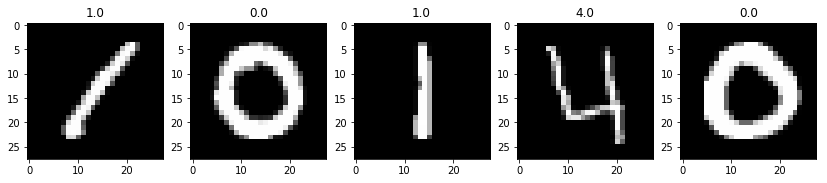

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

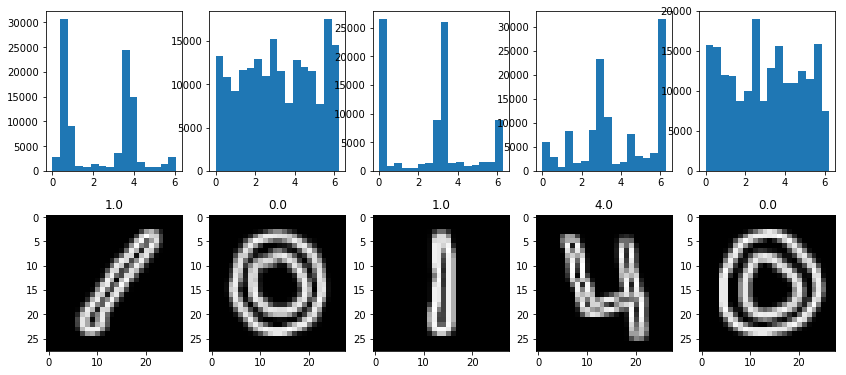

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [478]:
def circle(hist, frac=0.25):
    frac = max(1, int(frac * len(hist)))
    max_idx = np.argmax(hist)
    shift = max_idx - max_idx // frac * frac
    return np.hstack([hist[-shift:], hist[:-shift]])

def flip(hist):
    i = len(hist) // 2
    return hist[:i] + hist[i:]

In [11]:
masks = []

height, width = train_img[0].shape

heights = [0, height // 2, height]
widths = [0, width // 2, width]

for h in range(len(heights) - 1):
    for w in range(len(widths) - 1):
        mask = np.zeros((height,width))
        mask[heights[h]:heights[h+1], widths[w]:widths[w+1]] = 1
        masks.append(mask)

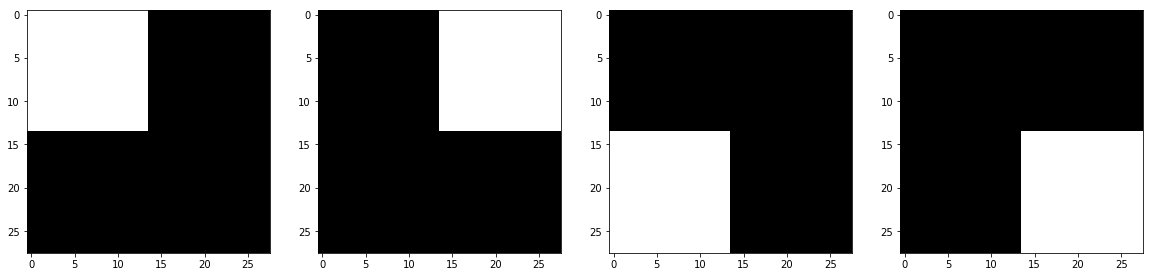

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(masks):
    subplot = fig.add_subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')

In [192]:

def circle_shift(hist, frac=0.125):
    sector = max(1, int(len(hist) * frac))
    max_idx = np.argmax(hist)
    shift = max_idx % sector
    if shift > (sector - shift):
        shift = shift - sector
    return np.hstack([hist[shift:], hist[:shift]])

def calc_hist(theta, grad, bins=16, flip=True, circle=True, masks=masks):
    width = bins * len(masks)
    result = np.zeros((len(theta), width))
    range_ = (0., 2. * np.pi)
    if flip:
        range_ = (0, np.pi)
        theta = np.where(theta >= np.pi, theta - np.pi, theta)
    for i in range(len(theta)):
        hists = []
        for mask in masks:
            weights = grad[i] * mask
            hist, _ = np.histogram(theta[i],
                                   bins=bins,
                                   range=range_,
                                   weights=weights)
            if circle:
                hist = circle_shift(hist)
            hists.append(hist)
        result[i] = np.hstack(hists)
    return result

In [193]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = calc_hist(train_theta, train_g)
test_hist = calc_hist(test_theta, test_g)

## Нормируем вектор гистограммы

In [194]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [195]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [196]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [197]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [198]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

In [199]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.764285714286


## Строим SVM

In [109]:
from sklearn.svm import SVC
svc = SVC().fit(x_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, svc.predict(x_val)))

## Строим модель GBM

In [133]:
from sklearn.ensemble import GradientBoostingClassifier

# bins=16, flip=True, circle=False, n_estimators=1000, subsample=0.8, max_features='sqrt', Accuracy: 0.95630952381
# bins=16, flip=True, circle=False, n_estimators=1000, subsample=0.8, max_features='sqrt', 

gbm = GradientBoostingClassifier(n_estimators=1000, 
                                 subsample=0.8, 
                                 max_features='sqrt',
                                 verbose=2).fit(x_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       54964.9830        1710.0368            8.97m
         2       50222.0375        1144.6792            8.09m
         3       46294.1271         972.4468            8.66m
         4       42700.3904         862.5364            8.42m
         5       39733.6033         738.1770            8.24m
         6       37163.8921         607.6411            8.05m
         7       34885.0905         546.0245            7.90m
         8       32911.3475         490.3587            7.79m
         9       31213.9938         425.6256            7.70m
        10       29485.3975         426.9496            7.68m
        11       27968.8302         367.8556            7.65m
        12       26619.1877         316.6446            7.63m
        13       25308.4204         291.3537            7.62m
        14       24225.5592         266.9097            7.61m
        15       23139.2422         253.9688            7.59m
       

       133        4310.5512           2.8672            6.73m
       134        4255.2070           2.1119            6.72m
       135        4284.4645           1.5639            6.70m
       136        4243.9823           5.0939            6.69m
       137        4226.1267           2.4490            6.68m
       138        4193.0954           1.6461            6.66m
       139        4168.3853           2.6465            6.65m
       140        4119.1841           3.7976            6.64m
       141        4083.1348           2.9423            6.63m
       142        4075.9602           1.5096            6.62m
       143        4092.6736           1.3636            6.60m
       144        4075.4275           1.6796            6.59m
       145        4010.0137           2.3003            6.58m
       146        4020.1361           2.2967            6.57m
       147        3915.9121           3.5236            6.56m
       148        3928.8558           1.9742            6.55m
       1

       266        2056.7976           0.4571            5.52m
       267        2068.1225          -0.2731            5.51m
       268        2040.3642          -0.1973            5.50m
       269        2051.4987           0.1524            5.50m
       270        2033.3433          -0.1312            5.49m
       271        2062.9136          -0.1446            5.48m
       272        2045.7162           0.0875            5.47m
       273        2025.0145          -0.0216            5.47m
       274        2045.9261           0.2081            5.46m
       275        2004.3581           0.1405            5.45m
       276        2008.3707          -0.1406            5.44m
       277        1972.6381          -0.1043            5.43m
       278        1980.8050           0.0114            5.43m
       279        1951.5875          -0.2309            5.42m
       280        1950.6750          -0.0405            5.41m
       281        1915.9042          -0.1717            5.40m
       2

       399        1153.4209          -0.2096            4.79m
       400        1136.5808          -0.3826            4.78m
       401        1126.0618          -0.2498            4.77m
       402        1122.7315          -0.2439            4.76m
       403        1113.9720          -0.4404            4.76m
       404        1125.8617          -0.1839            4.75m
       405        1118.4776          -0.2376            4.74m
       406        1117.1790           0.1518            4.73m
       407        1107.2809          -0.5001            4.72m
       408        1096.0487          -0.1381            4.72m
       409        1096.1778          -0.3928            4.71m
       410        1082.3321          -0.1463            4.71m
       411        1085.8443          -0.4431            4.71m
       412        1092.1271          -0.1690            4.71m
       413        1062.3520          -0.1092            4.70m
       414        1059.5030          -0.5076            4.70m
       4

       532         672.6898          -0.1339            3.71m
       533         671.3365          -0.2081            3.70m
       534         668.5018          -0.0561            3.69m
       535         654.5816          -0.1833            3.69m
       536         650.2299          -0.2593            3.68m
       537         644.7573          -0.3640            3.67m
       538         659.4632          -0.2087            3.66m
       539         638.1978          -0.0727            3.65m
       540         639.4021          -0.0286            3.64m
       541         637.7129          -0.2561            3.63m
       542         647.2471          -0.2345            3.63m
       543         643.7054          -0.1916            3.62m
       544         641.1445          -0.1767            3.61m
       545         640.7973          -0.0788            3.60m
       546         628.8049          -0.2478            3.59m
       547         626.1062          -0.2325            3.58m
       5

       665         413.2431          -0.1180            2.65m
       666         411.0717          -0.0201            2.64m
       667         413.3117          -0.2077            2.63m
       668         406.4359          -0.2138            2.62m
       669         404.8817          -0.1136            2.62m
       670         401.6918          -0.1383            2.61m
       671         399.0375          -0.2720            2.60m
       672         401.8666          -0.1684            2.59m
       673         403.3633          -0.1163            2.58m
       674         400.7032          -0.1484            2.57m
       675         400.2287          -0.1893            2.57m
       676         400.6122          -0.0863            2.56m
       677         393.7545          -0.2200            2.55m
       678         401.8095          -0.0603            2.54m
       679         387.6745          -0.1419            2.53m
       680         393.0685          -0.1133            2.52m
       6

       798         259.8595          -0.0978            1.62m
       799         260.3133          -0.0313            1.61m
       800         255.6959          -0.1839            1.60m
       801         257.9060          -0.0339            1.59m
       802         257.0073          -0.1180            1.59m
       803         254.1678          -0.1257            1.58m
       804         256.2920          -0.0748            1.57m
       805         253.8238          -0.1121            1.56m
       806         254.6417          -0.0430            1.55m
       807         251.4826          -0.1316            1.55m
       808         250.5886          -0.0115            1.54m
       809         249.2196          -0.0847            1.53m
       810         248.6020          -0.1023            1.52m
       811         247.6216          -0.0578            1.51m
       812         248.0362          -0.0770            1.51m
       813         248.5887          -0.1078            1.50m
       8

       931         165.7495          -0.0500           32.95s
       932         164.5797          -0.0615           32.47s
       933         162.9329          -0.0597           32.00s
       934         163.4727          -0.0595           31.52s
       935         164.5890          -0.0813           31.04s
       936         163.8205          -0.0589           30.55s
       937         162.7781          -0.0856           30.07s
       938         160.8592          -0.0409           29.59s
       939         162.3982          -0.0290           29.12s
       940         164.1155          -0.0303           28.64s
       941         161.1197          -0.0508           28.17s
       942         159.1223          -0.0611           27.69s
       943         159.4308          -0.0475           27.21s
       944         159.5806          -0.0424           26.73s
       945         157.6198          -0.0497           26.25s
       946         158.6546          -0.0476           25.77s
       9

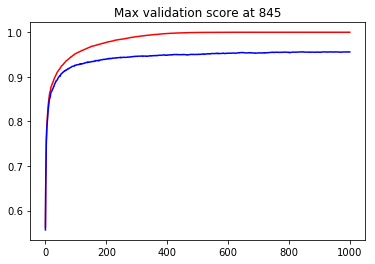

In [135]:
from sklearn.metrics import accuracy_score

val_acc = np.zeros(gbm.n_estimators, dtype=np.float32)
train_acc = np.zeros(gbm.n_estimators, dtype=np.float32)

for i, y_pred in enumerate(gbm.staged_predict(x_val)):
    val_acc[i] = accuracy_score(y_val, y_pred)
    
for i, y_pred in enumerate(gbm.staged_predict(x_train)):
    train_acc[i] = accuracy_score(y_train, y_pred)
    
plt.plot(list(range(gbm.n_estimators)), train_acc, 'r-',
         list(range(gbm.n_estimators)), val_acc, 'b-')

plt.title('Max validation score at %d' % np.argmax(val_acc))

In [136]:
pred_val = list(gbm.staged_predict(x_val))[np.argmax(val_acc)]

## Оцениваем качество решение на валидационной выборке

In [138]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.95630952381


In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       816
        1.0       0.99      0.98      0.98       909
        2.0       0.95      0.96      0.95       846
        3.0       0.95      0.94      0.95       937
        4.0       0.95      0.94      0.94       839
        5.0       0.97      0.96      0.96       702
        6.0       0.96      0.97      0.97       785
        7.0       0.96      0.96      0.96       893
        8.0       0.93      0.94      0.94       835
        9.0       0.94      0.95      0.94       838

avg / total       0.96      0.96      0.96      8400



In [140]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[799   1   4   0   1   0   2   4   3   2]
 [  3 887   3   0   8   0   3   1   3   1]
 [  2   2 811  14   6   0   0   2   7   2]
 [  3   0  11 881   0  11   0   6  19   6]
 [  0   2   8   0 790   0  10   3   7  19]
 [  0   0   0  11   2 672   9   1   7   0]
 [  8   1   0   0   9   2 762   0   3   0]
 [  0   2  13   4   4   0   1 853   4  12]
 [  8   2   3  10   4   7   5   5 786   5]
 [  5   3   2   7  10   1   0  11   7 792]]


## Предсказания на тестовыйх данных

In [141]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

In [142]:
pred_test = np.uint8(list(gbm.staged_predict(test_hist))[np.argmax(val_acc)])

## Визуализируем предсказания

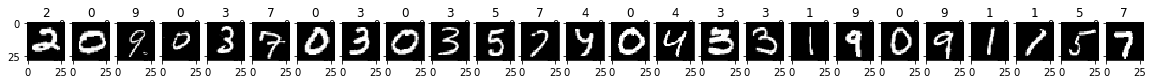

In [143]:
digits_to_show = 25
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:digits_to_show], 1):
    subplot = fig.add_subplot(1, digits_to_show, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [119]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [270]:
# Your submission scored 0.41700